In [1]:
import gammapy 
print(f'loaded gammapy version: {gammapy.__version__} ' )
print(f'Supposed to be 1.0 (21-12-2022)' )

loaded gammapy version: 1.0 
Supposed to be 1.0 (21-12-2022)


In [2]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit, Parameter, Parameters, Covariance
from gammapy.datasets import MapDataset #, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    ExpCutoffPowerLawSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys

from Dataset_Creation import sys_dataset

## Read dataset

spatial binsize =  [0.08] deg
MapDataset
----------

  Name                            : 1MUXqVCD 

  Total counts                    : 361088 
  Total background counts         : 360331.31
  Total excess counts             : 756.96

  Predicted counts                : 361088.27
  Predicted background counts     : 360331.34
  Predicted excess counts         : 756.93

  Exposure min                    : 2.07e-01 m2 s
  Exposure max                    : 2.41e+11 m2 s

  Number of total bins            : 540000 
  Number of fit bins              : 180191 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -752490.77

  Number of models                : 2 
  Number of parameters            : 13
  Number of free parameters       : 8

  Component 0: SkyModel
  
    Name                      : Source
    Datasets names            : None
    Spectral model type       : ExpCutoffPowerLawSpectralModel
    Spatial  model type       : GaussianSpatialModel
    Temporal mo

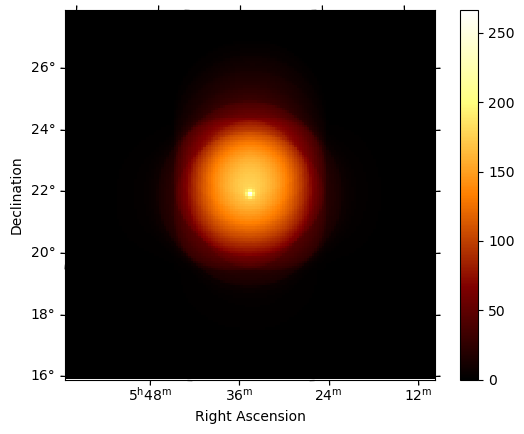

In [3]:
# immport the Crab paths, this is the basis of our simulation
# Read in the dataset
dataset_asimov = MapDataset.read("c:/users/yt02izug/downloads/dataset_asimov/dataset_asimov.fits")
# Create the spatial model 

model_spatial = GaussianSpatialModel(
    lon_0="83.631 deg",
    lat_0="22.018 deg",
    sigma="0.02 deg",
    )
# Create the spectral model 

model_spectrum  = ExpCutoffPowerLawSpectralModel(
    index=2.3,
    amplitude="1e-12 TeV-1 cm-2 s-1",    )
# combine the spectral and the spatial model
source_model = SkyModel(spatial_model = model_spatial ,
                       spectral_model = model_spectrum,
                       name = "Source")    
models = Models(source_model)
# Create the model for the Background
bkg_model = FoVBackgroundModel(dataset_name=dataset_asimov.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)
# set the models in the dataset
dataset_asimov.models = models

dataset_asimov.counts = dataset_asimov.npred()
    
dataset_asimov.counts.sum_over_axes().plot(add_cbar=1)
binsize = dataset_asimov.geoms["geom"].width[1] / dataset_asimov.geoms["geom"].data_shape[1]
print(
    "spatial binsize = ",
    binsize
)

print(dataset_asimov)

## Varying the Exposure

In [4]:
factor_neg = -0.1
factor_pos = +0.1

In [5]:
sys_d_cor = sys_dataset(dataset_asimov, 0, False)
dataset_cor = sys_d_cor.create_dataset()

sys_d_neg = sys_dataset(dataset_asimov, factor_neg, False)
dataset_neg = sys_d_neg.create_dataset()

sys_d_pos = sys_dataset(dataset_asimov, factor_pos, False)
dataset_pos = sys_d_pos.create_dataset()



In [6]:
print(dataset_cor)

MapDataset
----------

  Name                            : DPKdhgPa 

  Total counts                    : 361088 
  Total background counts         : 360331.31
  Total excess counts             : 756.96

  Predicted counts                : 361088.27
  Predicted background counts     : 360331.34
  Predicted excess counts         : 756.93

  Exposure min                    : 2.07e-01 m2 s
  Exposure max                    : 2.41e+11 m2 s

  Number of total bins            : 540000 
  Number of fit bins              : 180191 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -752490.77

  Number of models                : 2 
  Number of parameters            : 13
  Number of free parameters       : 6

  Component 0: SkyModel
  
    Name                      : Source
    Datasets names            : None
    Spectral model type       : ExpCutoffPowerLawSpectralModel
    Spatial  model type       : GaussianSpatialModel
    Temporal model type       : 
    Paramete

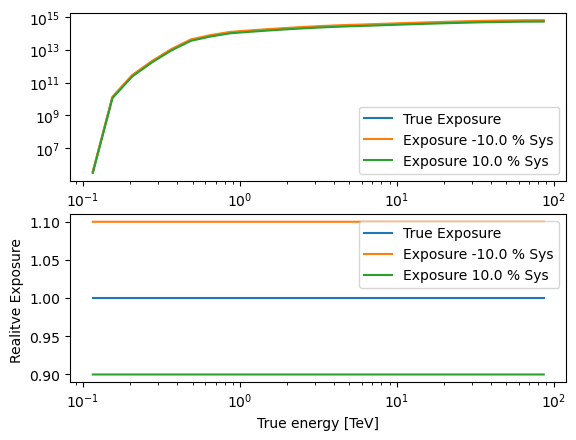

In [7]:
fig,ax = plt.subplots(2,1)

true_energy = dataset_cor.exposure.geom.axes[0].center.value
exposure_e = dataset_cor.exposure.data.sum(axis =2).sum(axis =1)

ax[0].plot(true_energy, exposure_e, label = "True Exposure")
ax[0].plot(true_energy, dataset_neg.exposure.data.sum(axis =2).sum(axis =1),
           label = "Exposure {:.3} % Sys".format(factor_neg *100))
ax[0].plot(true_energy, dataset_pos.exposure.data.sum(axis =2).sum(axis =1), 
           label = "Exposure {:.4} % Sys".format(factor_pos * 100))

ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].set_xlabel("")
#ax[0].set_ylabel(f"Eff. Area * Livetime [{dataset_standard.exposure.unit}]")
ax[0].legend()

ax[1].plot(true_energy, exposure_e/exposure_e, label = "True Exposure")
ax[1].plot(true_energy, (dataset_neg.exposure.data.sum(axis =2).sum(axis =1))/exposure_e,
           label = "Exposure {:.3} % Sys".format(factor_neg *100))
ax[1].plot(true_energy, (dataset_pos.exposure.data.sum(axis =2).sum(axis =1))/ exposure_e, 
           label = "Exposure {:.4} % Sys".format(factor_pos * 100))

#ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].set_xlabel("True energy [TeV]")
ax[1].set_ylabel(f"Realitve Exposure ")
ax[1].legend()

fig.savefig("plots/1_exposure_example.pdf")

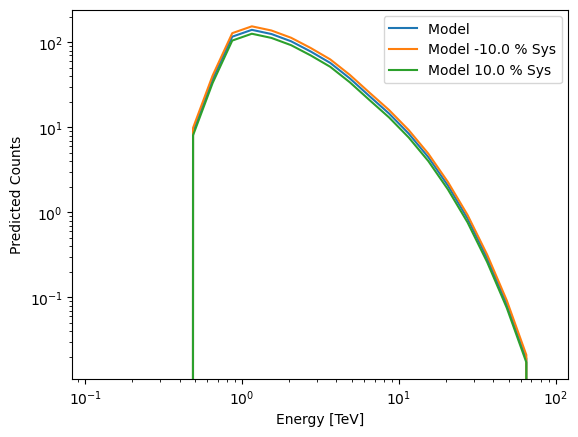

In [8]:
energy_bounds = energy_bounds =(true_energy[0], true_energy[-1] ) * u.TeV

npred = dataset_cor.npred_signal().data.sum(axis = 2).sum(axis= 1)
npred_neg = dataset_neg.npred_signal().data.sum(axis = 2).sum(axis= 1)
npred_pos = dataset_pos.npred_signal().data.sum(axis = 2).sum(axis= 1)


plt.plot(true_energy, npred, label = "Model ")
plt.plot(true_energy, npred_neg, label = "Model {:.3} % Sys".format(factor_neg *100))
plt.plot(true_energy, npred_pos, label = "Model {:.4} % Sys".format(factor_pos * 100))

         
plt.loglog()
plt.legend()
plt.xlabel("Energy [TeV]")
plt.ylabel("Predicted Counts")

fig = plt.gcf()
fig.savefig("plots/1_counts.pdf")

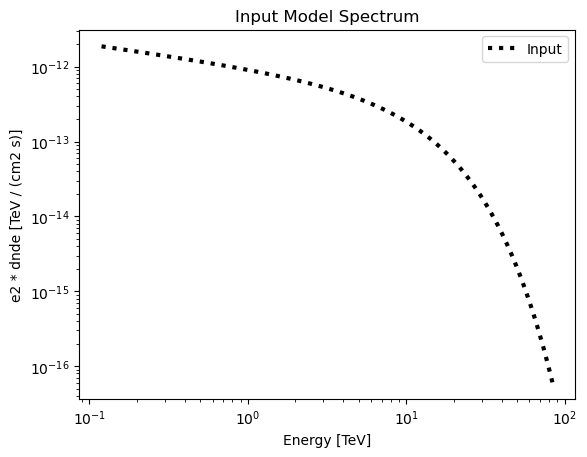

In [9]:
energy_bounds = energy_bounds =(true_energy[0], true_energy[-1] ) * u.TeV
#dataset_cor.models['Source'].spectral_model.plot(energy_bounds, label = "Spectrum")
#dataset_neg.models['Source'].spectral_model.plot(energy_bounds, label = "")
#dataset_pos.models['Source'].spectral_model.plot(energy_bounds, label = "")
dataset_asimov.models['Source'].spectral_model.plot(energy_bounds, energy_power = 2,
                                label = "Input", color = 'black', linewidth = 3, linestyle ='dotted')
plt.title("Input Model Spectrum")
plt.legend()

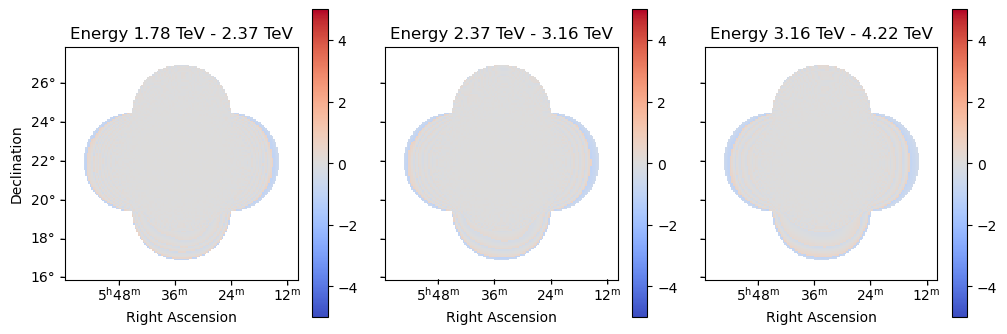

In [10]:
estimator = ExcessMapEstimator(
    correlation_radius=f"0.2 deg",
    energy_edges=dataset_cor.counts.geom.axes['energy'].edges[10:14])
result = estimator.run(dataset_cor)
result["sqrt_ts"].plot_grid(cmap="coolwarm", add_cbar=True, vmin=-5, vmax=5,);

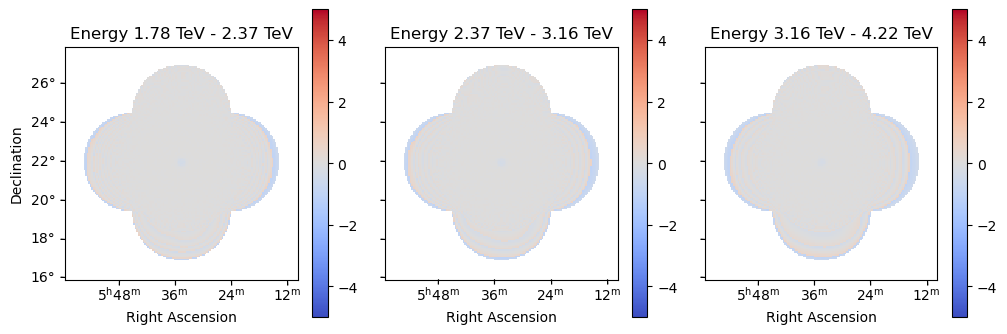

In [11]:
result = estimator.run(dataset_neg)
result["sqrt_ts"].plot_grid(cmap="coolwarm", add_cbar=True, vmin=-5, vmax=5,);

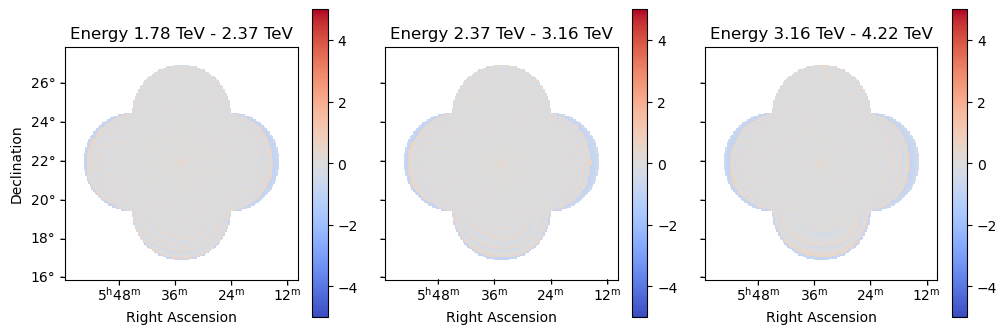

In [12]:
result = estimator.run(dataset_pos)
result["sqrt_ts"].plot_grid(cmap="coolwarm", add_cbar=True, vmin=-5, vmax=5,);

In [13]:
%%time
fit_cor = Fit(store_trace=False)
result_cor = fit_cor.run([dataset_cor])
fit_neg = Fit(store_trace=False)
result_neg = fit_neg.run([dataset_neg])
fit_pos = Fit(store_trace=False)
result_pos = fit_pos.run([dataset_pos])

CPU times: total: 13.4 s
Wall time: 13.4 s


In [14]:
datasets_short = [dataset_neg, dataset_cor, dataset_pos]
print("best fit amplitude")
amplitudes = []
m = dataset_asimov.models['Source']
value = m.parameters['amplitude'].value 
error = m.parameters['amplitude'].error
amplitudes.append((value, error))
print('====')
print('Input')
print(f'{value} pm {error}')
print('====')
for d in datasets_short:
    m = d.models['Source']
    value = m.parameters['amplitude'].value 
    error = m.parameters['amplitude'].error
    amplitudes.append((value, error))
    print(f'{value} pm {error}')
print()
print("best fit Index")
indices = []
m = dataset_asimov.models['Source']
value = m.parameters['index'].value 
error = m.parameters['index'].error
indices.append((value, error))
print('====')
print('Input')
print(f'{value} pm {error}')
print('====')
for d in datasets_short:
    m = d.models['Source']
    value = m.parameters['index'].value 
    error = m.parameters['index'].error
    indices.append((value, error))
    print(f'{value} pm {error}')
print()

print("Best Fit bkg Norm")
norms = []
value = dataset_asimov.background_model.parameters['norm'].value 
error = dataset_asimov.background_model.parameters['norm'].error
norms.append((value, error))
print('====')
print('Input')
print(f'{value} pm {error}')
print('====')
for d in datasets_short:
    value = d.background_model.parameters['norm'].value 
    error = d.background_model.parameters['norm'].error
    print(f'{value} pm {error}')
    norms.append((value, error))
print()   
    
print("Best Fit Lambda Norm")
lambdas = []
value = dataset_asimov.models.parameters['lambda_'].value 
error = dataset_asimov.models.parameters['lambda_'].error
lambdas.append((value, error))
print('====')
print('Input')
print(f'{value} pm {error}')
print('====')
for d in datasets_short:
    value = d.models.parameters['lambda_'].value 
    error = d.models.parameters['lambda_'].error
    print(f'{value} pm {error}')
    lambdas.append((value, error))
    
    
with open('data/1_norms.yaml', 'w') as file:
    documents = yaml.dump(norms, file)
with open('data/1_amplitudes.yaml', 'w') as file:
    documents = yaml.dump(amplitudes, file)
with open('data/1_indices.yaml', 'w') as file:
    documents = yaml.dump(indices, file)
with open('data/1_lambda.yaml', 'w') as file:
    documents = yaml.dump(lambdas, file)
    
dataset_neg.models.write("data/1_model_neg.yml", overwrite= True)
dataset_pos.models.write("data/1_model_pos.yml", overwrite= True)
dataset_cor.models.write("data/1_model_cor.yml", overwrite= True)

best fit amplitude
====
Input
1e-12 pm 0
====
9.119417320485696e-13 pm 1.1352141078482069e-13
1.0000014085394713e-12 pm 1.2284181256941673e-13
1.113404470361341e-12 pm 1.372050951976678e-13

best fit Index
====
Input
2.3 pm 0
====
2.2932656623447274 pm 0.1607779596098793
2.3000147784348908 pm 0.15727399203008516
2.3018099842435285 pm 0.1574622503158369

Best Fit bkg Norm
====
Input
1.0 pm 0
====
1.000017142130433 pm 0.00205601337870186
1.000000087926757 pm 0.002066539512841799
0.9999908326240797 pm 0.0020665531569145495
Best Fit Lambda Norm
====
Input
0.1 pm 0
====
0.10278124093494943 pm 0.05002339037118561
0.10000479938905592 pm 0.04732152509820457
0.10025182042511319 pm 0.047551174483361075


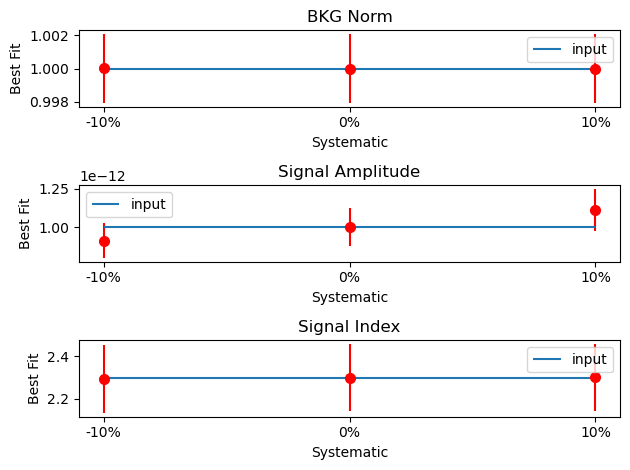

In [15]:
fig, axs = plt.subplots(3,1)

axs[0].set_title("BKG Norm")
axs[1].set_title("Signal Amplitude")
axs[2].set_title("Signal Index")


labels = [ '-10%', '0%', '10%']

for i, a in enumerate(norms[1:]):
    axs[0].errorbar(x= i+1, y = a[0], yerr = a[1], fmt= 'o', color =  'red',markersize=7)
axs[0].hlines( norms[0][0], 1, 3, label = "input")

for i, a in enumerate(amplitudes[1:]):
    axs[1].errorbar(x= i+1, y = a[0], yerr = a[1], fmt= 'o', color =  'red',markersize=7)
axs[1].hlines( amplitudes[0][0], 1, 3, label = "input")

for i, a in enumerate(indices[1:]):
    axs[2].errorbar(x= i+1, y = a[0], yerr = a[1], fmt= 'o', color =  'red',markersize=7)
axs[2].hlines( indices[0][0], 1, 3, label = "input")

plt.tight_layout()
for a in axs:
    a.legend(); 
    a.set_ylabel('Best Fit'); 
    a.set_xlabel('Systematic'); 
    a.set_xticks(np.arange(3)+1,labels)

plt.tight_layout()    
fig.savefig("plots/1_best_fit_parameters_standard.pdf")   


index
amplitude
lambda_
index
amplitude
lambda_
index
amplitude
lambda_
index
amplitude
lambda_
index
amplitude
lambda_
index
amplitude
lambda_


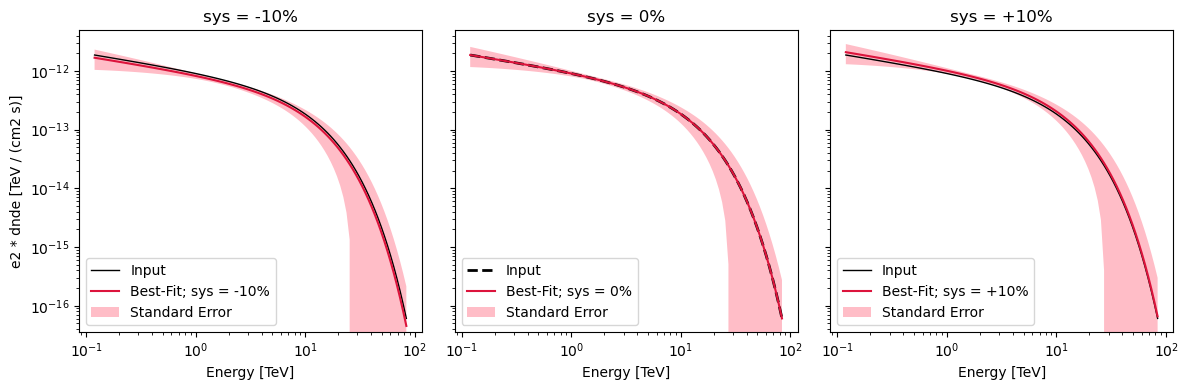

In [16]:
energy_bounds = (true_energy[0], true_energy[-1] ) * u.TeV

fig,axs = plt.subplots(1,3, sharey=True,figsize = (12,4))

for i,ax in enumerate(axs):
    if i ==1:
         dataset_asimov.models[0].spectral_model.plot(energy_bounds, energy_power = 2, ax =ax, 
                                label = "Input", color = 'black', linewidth = 2, linestyle="dashed")
    else:
        dataset_asimov.models[0].spectral_model.plot(energy_bounds, energy_power = 2, ax =ax, 
                                label = "Input", color = 'black', linewidth = 1, )

dataset_neg.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[0],
                                label = "Best-Fit; sys = -10%", color = "crimson")
dataset_neg.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[0],
                                                       facecolor='lightpink',
                                                          alpha = 0.9,
                                                          label= "Standard Error"
                                                         )

dataset_cor.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[1],
                                label = "Best-Fit; sys = 0%", color = "crimson")
dataset_cor.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[1],
                                                       facecolor='lightpink',
                                                          alpha = 0.9,
                                                          label= "Standard Error"
                                                         )

dataset_pos.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[2],
                                label = "Best-Fit; sys = +10%", color = "crimson")
dataset_pos.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[2],
                                                       facecolor='lightpink',
                                                          alpha = 0.9,
                                                          label= "Standard Error"
                                                         )
[a.legend() for a in axs]
axs[0].set_title("sys = -10%"); axs[1].set_title("sys = 0%"); axs[2].set_title("sys = +10%"); 

axs[1].set_ylabel('')
axs[2].set_ylabel('')

plt.tight_layout()
fig = plt.gcf()
fig.savefig("plots/1_spectrum_standard.pdf")

In [17]:
print(dataset_cor)

MapDataset
----------

  Name                            : DPKdhgPa 

  Total counts                    : 361088 
  Total background counts         : 360331.31
  Total excess counts             : 756.96

  Predicted counts                : 361088.35
  Predicted background counts     : 360331.35
  Predicted excess counts         : 756.99

  Exposure min                    : 2.07e-01 m2 s
  Exposure max                    : 2.41e+11 m2 s

  Number of total bins            : 540000 
  Number of fit bins              : 180191 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -752490.77

  Number of models                : 2 
  Number of parameters            : 13
  Number of free parameters       : 6

  Component 0: SkyModel
  
    Name                      : Source
    Datasets names            : None
    Spectral model type       : ExpCutoffPowerLawSpectralModel
    Spatial  model type       : GaussianSpatialModel
    Temporal model type       : 
    Paramete

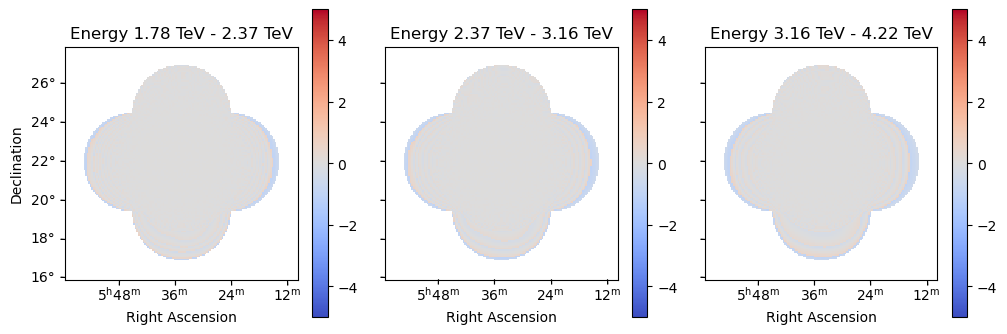

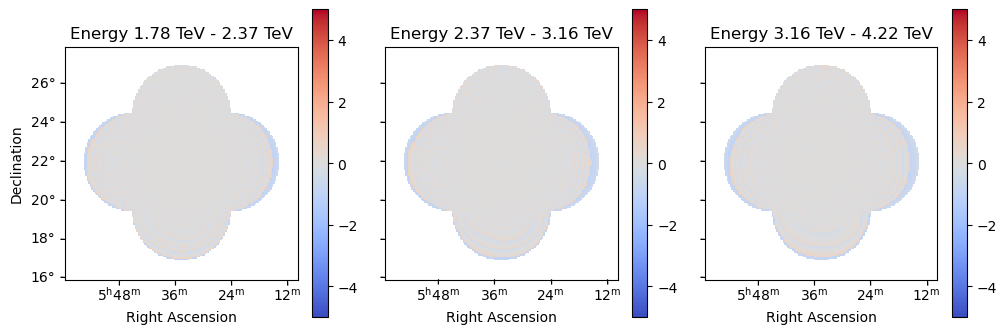

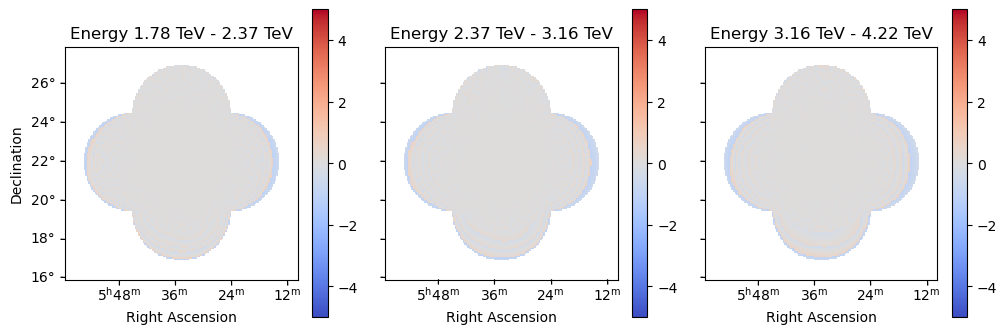

In [18]:

estimator = ExcessMapEstimator(
    correlation_radius=f"0.2 deg",
    energy_edges=dataset_cor.counts.geom.axes['energy'].edges[10:14])
result = estimator.run(dataset_cor)
result["sqrt_ts"].plot_grid(cmap="coolwarm", add_cbar=True, vmin=-5, vmax=5,);


result = estimator.run(dataset_neg)
result["sqrt_ts"].plot_grid(cmap="coolwarm", add_cbar=True, vmin=-5, vmax=5,);


result = estimator.run(dataset_pos)
result["sqrt_ts"].plot_grid(cmap="coolwarm", add_cbar=True, vmin=-5, vmax=5,);